# Step 6: Finetune your model
### hyperparametes:
* Hyperparameters are external configurations of the model set by you—not learned from the data.
* They're not part of the training data—they're the rules for how the training happens.

| Algorithm                | Hyperparameter Example         | What It Controls                                 |
|--------------------------|-------------------------------|--------------------------------------------------|
| Decision Tree            | `max_depth`                   | How deep the tree can go                         |
| Random Forest            | `n_estimators`                | How many trees to grow                           |
| Linear Regression        | None (pure version)           | But with regularization: `alpha`, `penalty`      |
| K-Nearest Neighbors (KNN)| `n_neighbors`                 | How many neighbors to consider                   |
| Gradient Boosting        | `learning_rate`, `n_estimators` | How slow and how many boosting rounds            |
| Neural Networks          | `learning_rate`, `epochs`, `batch_size` | How fast to learn and in what chunks   |

* tuning these hyperparameters lead to better accuracy of ML models
* finding the best combination of hyperparameters is a search problem in the space of hyperparameters, which is huge

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(data_url, sep=";")

feature_list = data.columns[:-1].values
label = [data.columns[-1]]

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["quality"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

wine_features = strat_train_set.drop("quality", axis=1)
wine_labels = strat_train_set["quality"].copy()

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transform_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scalar", StandardScaler()),
])

wine_features_tr = transform_pipeline.fit_transform(wine_features)
wine_features_test = strat_test_set.drop("quality", axis=1)
wine_labels_test = strat_test_set["quality"].copy()

wine_features_test_tr = transform_pipeline.fit_transform(wine_features_test)

from sklearn.model_selection import cross_val_score

def display_scores(scores):
	print("Scores:", scores)
	print("Mean:", scores.mean())
	print("Standard deviation:", scores.std())

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(wine_features_tr, wine_labels)

scores = cross_val_score(forest_reg, wine_features_tr, wine_labels,
													scoring="neg_mean_squared_error", cv=10)
forest_reg_mse_scores = -scores
display_scores(forest_reg_mse_scores)

from sklearn.metrics import mean_squared_error

quality_predictions_test = forest_reg.predict(wine_features_test_tr)
mean_squared_error(wine_labels_test, quality_predictions_test)

Scores: [0.36739844 0.42645    0.28647812 0.31848594 0.21827656 0.30290391
 0.26400547 0.38975234 0.43522188 0.44921575]
Mean: 0.3458188404281496
Standard deviation: 0.07526725637378695


0.338606875

### grid search

In [21]:
from sklearn.model_selection import GridSearchCV

* we need to specify a list of parameters along with the range of valued to try.
* it automatically evaluates all possible combinations of hyperparameter values using cross validation

* in `RainForestrRegression` there are a no of hyperparameters such as
    * number of estimators
    * maximum no of features

In [22]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
	{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

total no of combinations:
* 3 x 4 = 12
* 2 x 3 = 6
* total 18

In [23]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
							scoring='neg_mean_squared_error',
                            return_train_score=True
                           )

* in this case we use cv=5, which means 5 fold cross validation for the training model
* we need to train the model for 18 parameter combinations and each combination would be trained 5 times for cross validation
* total model training runs = 18 x 5 = 90


In [24]:
grid_search.fit(wine_features_tr, wine_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
# to obtain the best parameter combination,
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [26]:
# lets find out errors at different parameter settings
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.4612486383442265 {'max_features': 2, 'n_estimators': 3}
0.3969692095588235 {'max_features': 2, 'n_estimators': 10}
0.3627460988562091 {'max_features': 2, 'n_estimators': 30}
0.473318695533769 {'max_features': 4, 'n_estimators': 3}
0.39521746323529416 {'max_features': 4, 'n_estimators': 10}
0.36219482570806105 {'max_features': 4, 'n_estimators': 30}
0.4851034858387798 {'max_features': 6, 'n_estimators': 3}
0.3851027267156862 {'max_features': 6, 'n_estimators': 10}
0.3672942810457516 {'max_features': 6, 'n_estimators': 30}
0.4806648284313725 {'max_features': 8, 'n_estimators': 3}
0.399130943627451 {'max_features': 8, 'n_estimators': 10}
0.364428250953159 {'max_features': 8, 'n_estimators': 30}
0.46901143790849675 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.3697358149509803 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.4806454248366013 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.375508118872549 {'bootstrap': False, 'max_features': 3, 'n_

In [27]:
# to obtain the best parameter combination,
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30)

### NOTE:
* the `GridSearchCV` is initialized with `refit = True` option, which retrains the best estimator on the full training set.
* this likely to lead us to a better model as it is trained on a larger dataset

### RandomizedSearchCV
* if the hyperparameter space is large its desirable to try `RandomizedSearchCV`  
* It selects a random value for each hyperparameter at the start of each iteration and
* repeats the process for the given number of random combinations.

In [28]:
from sklearn.model_selection import RandomizedSearchCV

### Analysis of best model

In [29]:
feature_importances = grid_search.best_estimator_.feature_importances_

sorted(zip(feature_importances, feature_list), reverse=True)

[(np.float64(0.20123793733971312), 'alcohol'),
 (np.float64(0.15612441177104025), 'sulphates'),
 (np.float64(0.12140026378553374), 'volatile acidity'),
 (np.float64(0.08160345574343617), 'density'),
 (np.float64(0.07937059645113335), 'total sulfur dioxide'),
 (np.float64(0.06826585562088457), 'chlorides'),
 (np.float64(0.06384550251068317), 'fixed acidity'),
 (np.float64(0.061419274750500734), 'pH'),
 (np.float64(0.06023793644746286), 'citric acid'),
 (np.float64(0.055451337201824935), 'residual sugar'),
 (np.float64(0.05104342837778729), 'free sulfur dioxide')]

* based on this information we can drop features that are not so important
* it is also useful to analyze the errors in prediction and understand its causes and fix them

In [32]:
### Evaluation

quality_predictions_test = grid_search.best_estimator_.predict(wine_features_test_tr)
mean_squared_error(wine_labels_test, quality_predictions_test)

0.3690381944444444

Text(0, 0.5, 'Predicted quality')

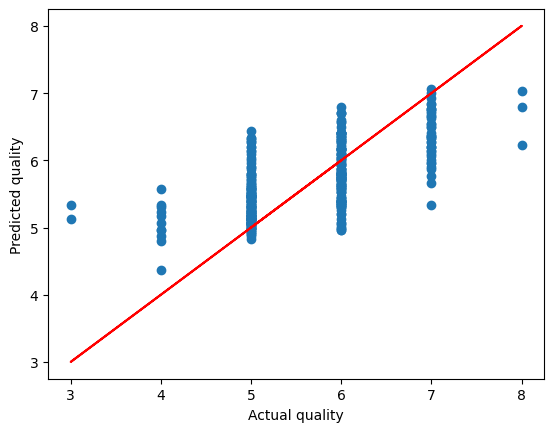

In [33]:
plt.scatter(wine_labels_test, quality_predictions_test)
plt.plot(wine_labels_test, wine_labels_test, "r-")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")

In [39]:
# its good idea to get confidence interval of the evaluation metric. It can be obtained by

from scipy import stats

confidence = 0.95
squared_errors = (quality_predictions_test - wine_labels_test) ** 2

stats.t.interval(confidence, len(squared_errors) - 1,
                 loc=squared_errors.mean(),
                 scale = stats.sem(squared_errors))

(np.float64(0.30240781607370665), np.float64(0.4356685728151822))

95% confidence interval is obtained in this range

# Step 7: Present your solution
Before launch,

1. We need to present our solution that highlights learnings, assumptions and systems limitation.
2.  Document everything, create clear visualizations and present the model.
3. In case, the model does not work better than the experts, it may still be a good idea to launch it and free up bandwidths of human experts.

# Step 8: Launch, monitor and maintain your system
* Launch
    * Plug in input sources
    * Write test cases
* Monitor
    * System outages
    * Degradation of model performance
    * Sampling predictions for human evaluation
    * Regular assessment of data quality, which is critical for model performance
* Maintain
    * Train model regularly every fixed interval with fresh data.
    * Production roll out of the model.